In [3]:
import os
import warnings
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
!pip install xgboost
from xgboost import XGBClassifier
!pip install tensorflow
from tensorflow import keras
!pip install imblearn
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load data
train_data = pd.read_csv('exoTrain.csv')
test_data = pd.read_csv('exoTest.csv')

In [8]:
train_data.head()

LABEL   FLUX.1   FLUX.2   FLUX.3   FLUX.4   FLUX.5   FLUX.6  FLUX.7  \
0      2    93.85    83.81    20.10   -26.98   -39.56  -124.71 -135.18   
1      2   -38.88   -33.83   -58.54   -40.09   -79.31   -72.81  -86.55   
2      2   532.64   535.92   513.73   496.92   456.45   466.00  464.50   
3      2   326.52   347.39   302.35   298.13   317.74   312.70  322.33   
4      2 -1107.21 -1112.59 -1118.95 -1095.10 -1057.55 -1034.48 -998.34   

    FLUX.8  FLUX.9  ...  FLUX.3188  FLUX.3189  FLUX.3190  FLUX.3191  \
0   -96.27  -79.89  ...     -78.07    -102.15    -102.15      25.13   
1   -85.33  -83.97  ...      -3.28     -32.21     -32.21     -24.89   
2   486.39  436.56  ...     -71.69      13.31      13.31     -29.89   
3   311.31  312.42  ...       5.71      -3.73      -3.73      30.05   
4 -1022.71 -989.57  ...    -594.37    -401.66    -401.66    -357.24   

   FLUX.3192  FLUX.3193  FLUX.3194  FLUX.3195  FLUX.3196  FLUX.3197  
0      48.57      92.54      39.32      61.42       5.08     -39.54  
1      -4.86       0.76     -11.70       6.46      16.00      19.93  
2     -20.88       5.06     -11.80     -28.91     -70.02     -96.67  
3      20.03     -12.67      -8.77     -17.31     -17.35      13.98  
4    -443.76    -438.54    -399.71    -384.65    -411.79    -510.54  

[5 rows x 3198 columns]

In [9]:
# Preprocess data
categ = {2: 1, 1: 0}
train_data.LABEL = train_data.LABEL.map(categ)
test_data.LABEL = test_data.LABEL.map(categ)

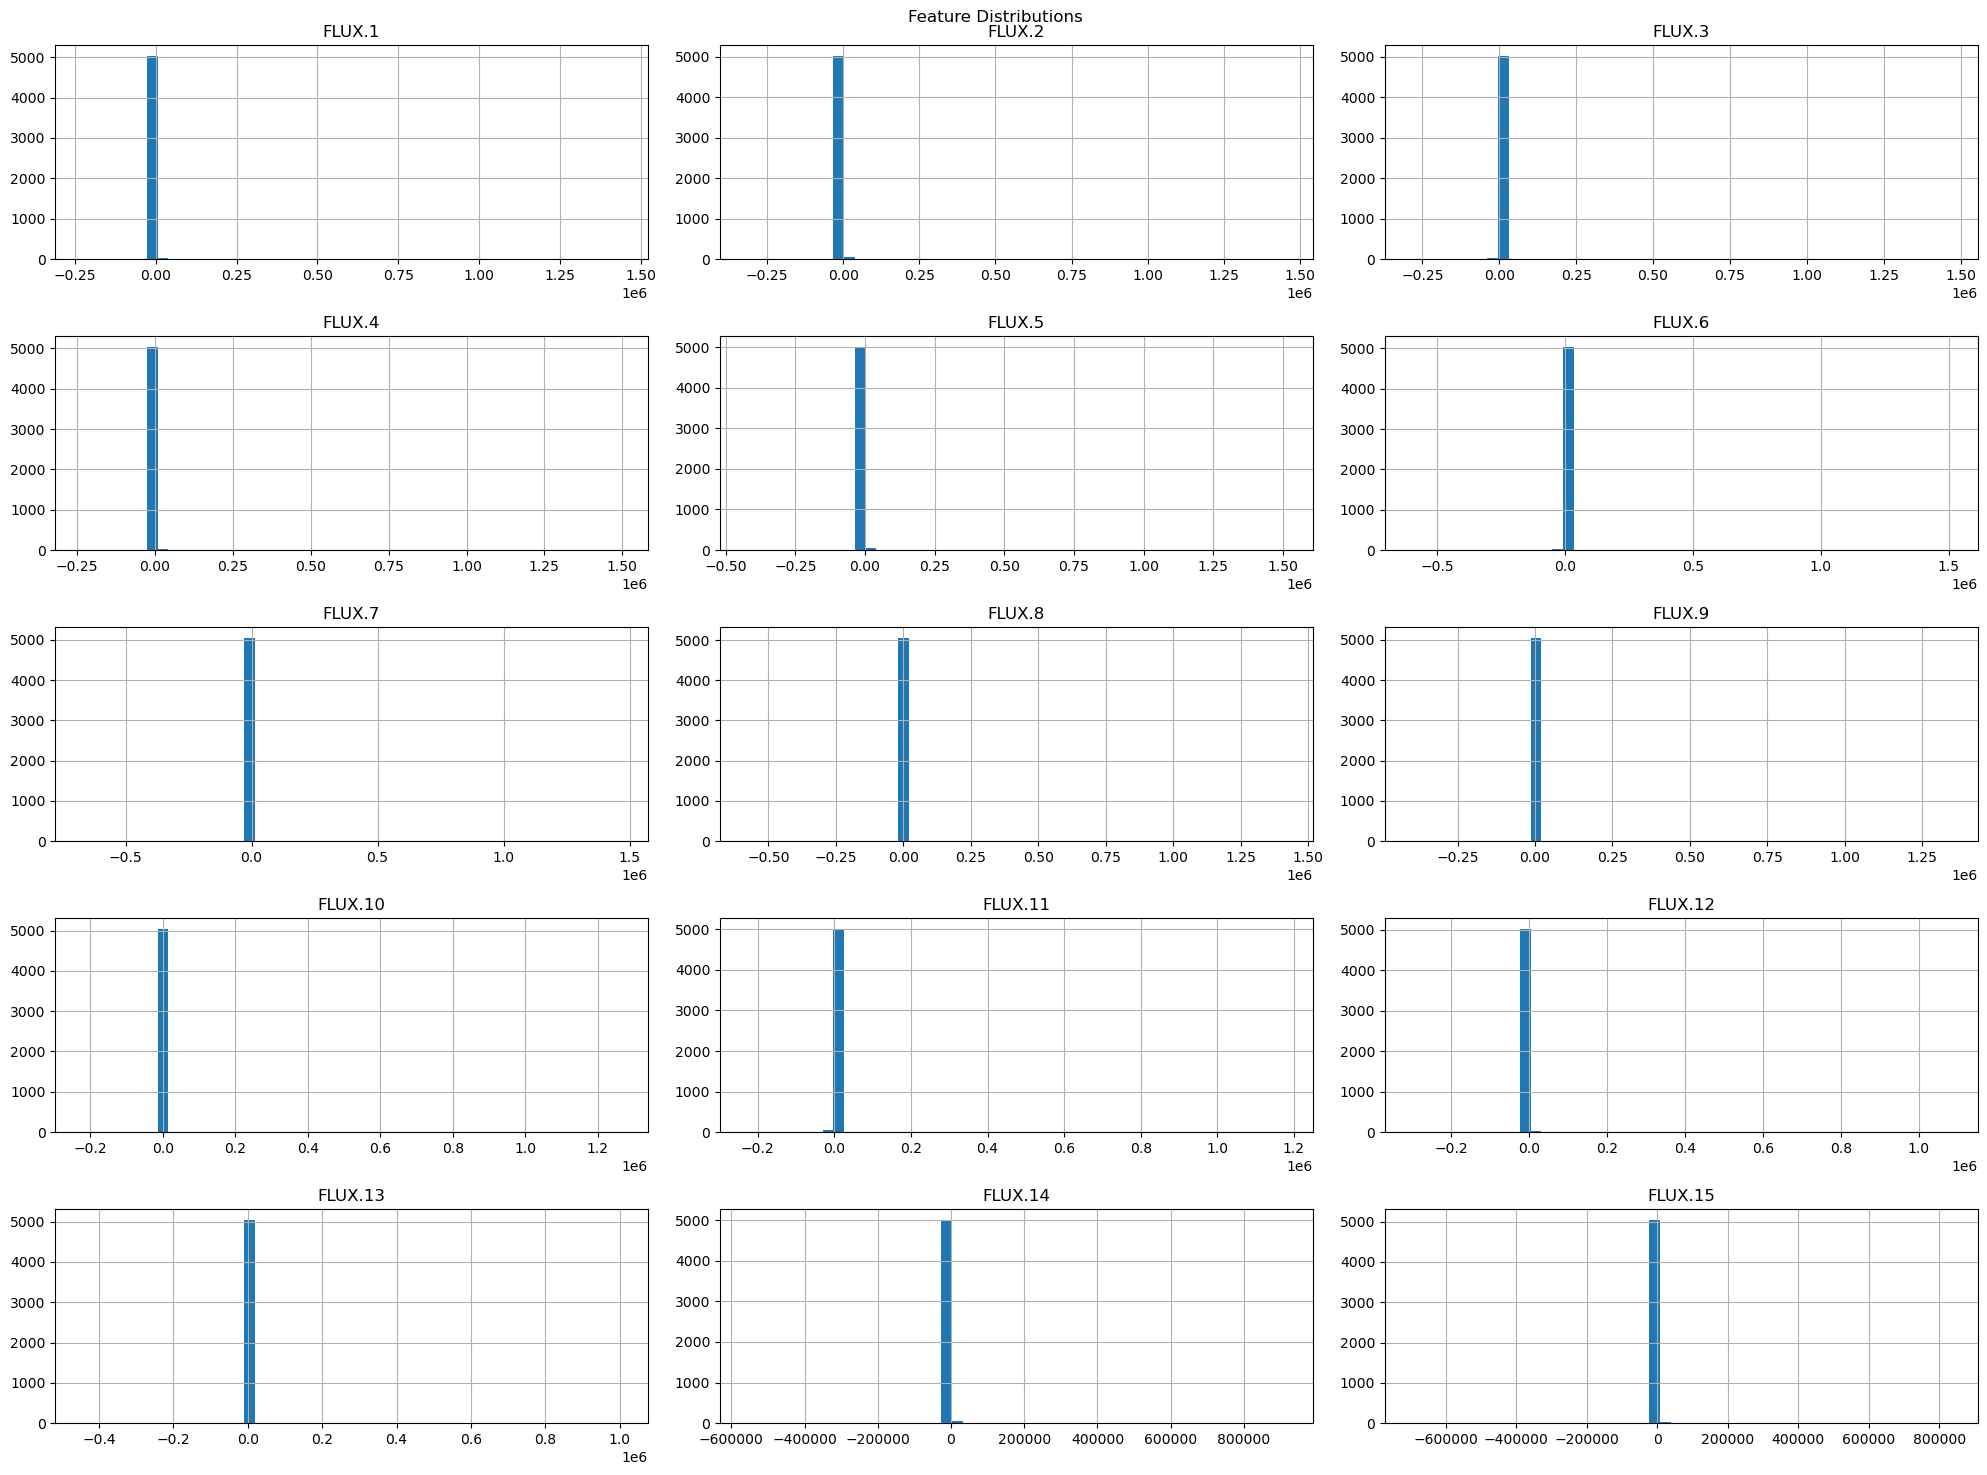

In [34]:
# Exploratory Data Visualization (EDV)
# Plot histograms for feature distributions
features = train_data.columns[1:16]
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features):
    plt.subplot(5, 3, i + 1)  
    train_data[feature].hist(bins=50)
    plt.title(feature)

plt.suptitle('Feature Distributions')
plt.tight_layout()
plt.show()

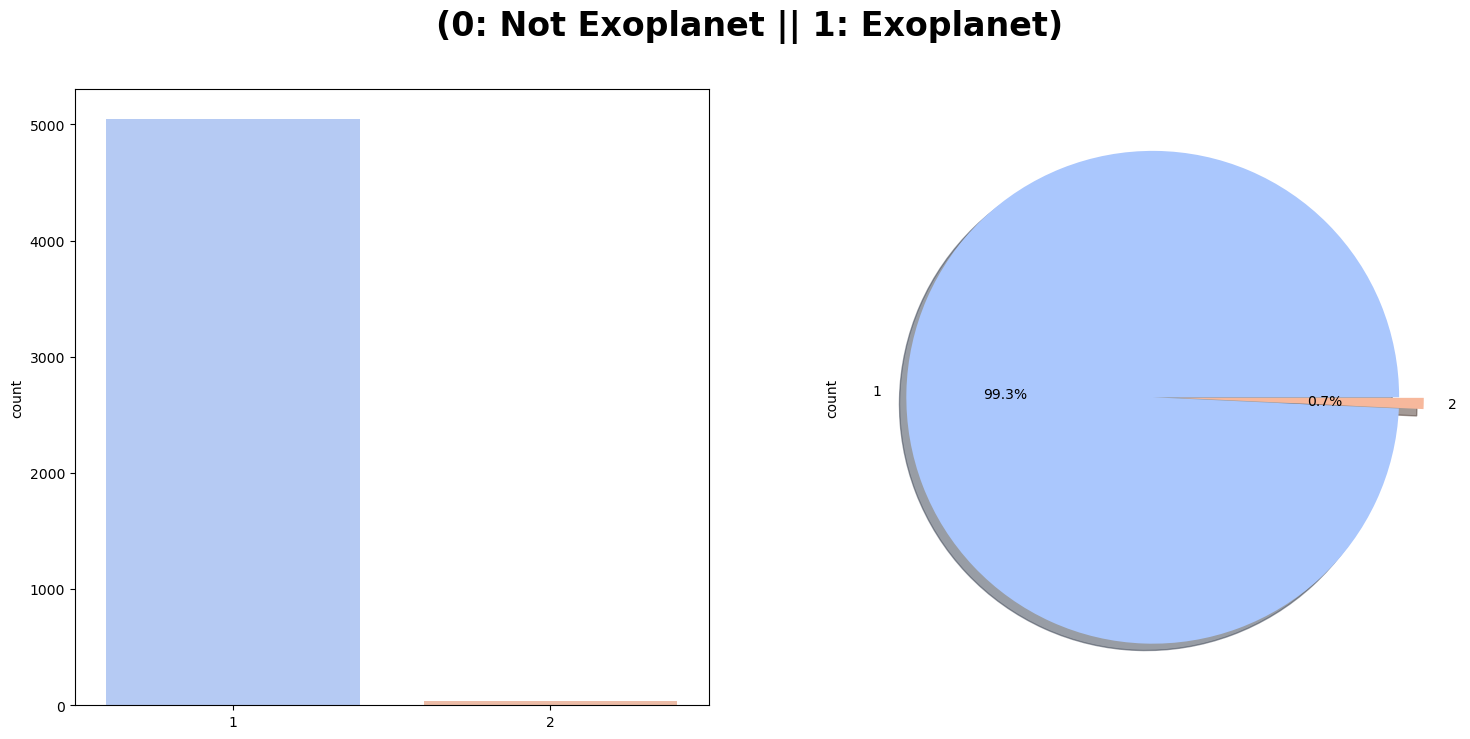

In [5]:
#Visualization to display the distribution of 'LABEL' column
# Create a figure with subplots
fig, ax = plt.subplots(1, 2, figsize=(18,8))

# Color palette for the count plot
sns.countplot(x='LABEL', data=train_data, palette='coolwarm', ax=ax[0])
ax[0].set_xlabel('')

# Colors for the pie chart
colors = sns.color_palette('coolwarm', 2)
train_data['LABEL'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[1], shadow=True, colors=colors)

# Set the title
fig.suptitle('(0: Not Exoplanet || 1: Exoplanet)\n', fontsize=24, fontweight='bold')

# Show the plot
plt.show()

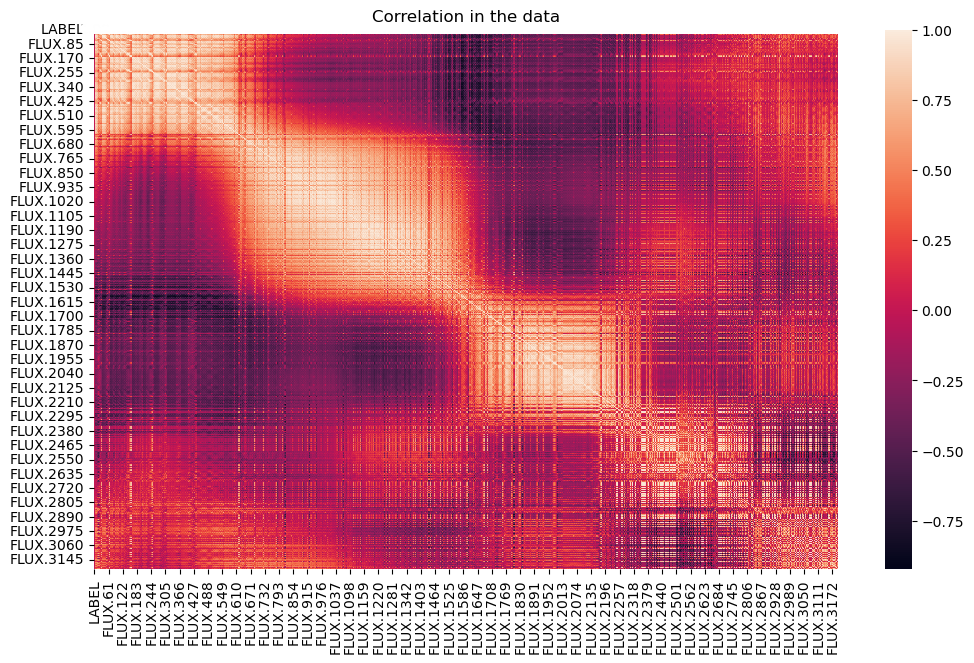

In [7]:
# EDA heatmap
plt.figure(figsize=(12, 7))
sns.heatmap(train_data.corr(), annot=True, fmt='.2f')
plt.title('Correlation in the data')
plt.show()

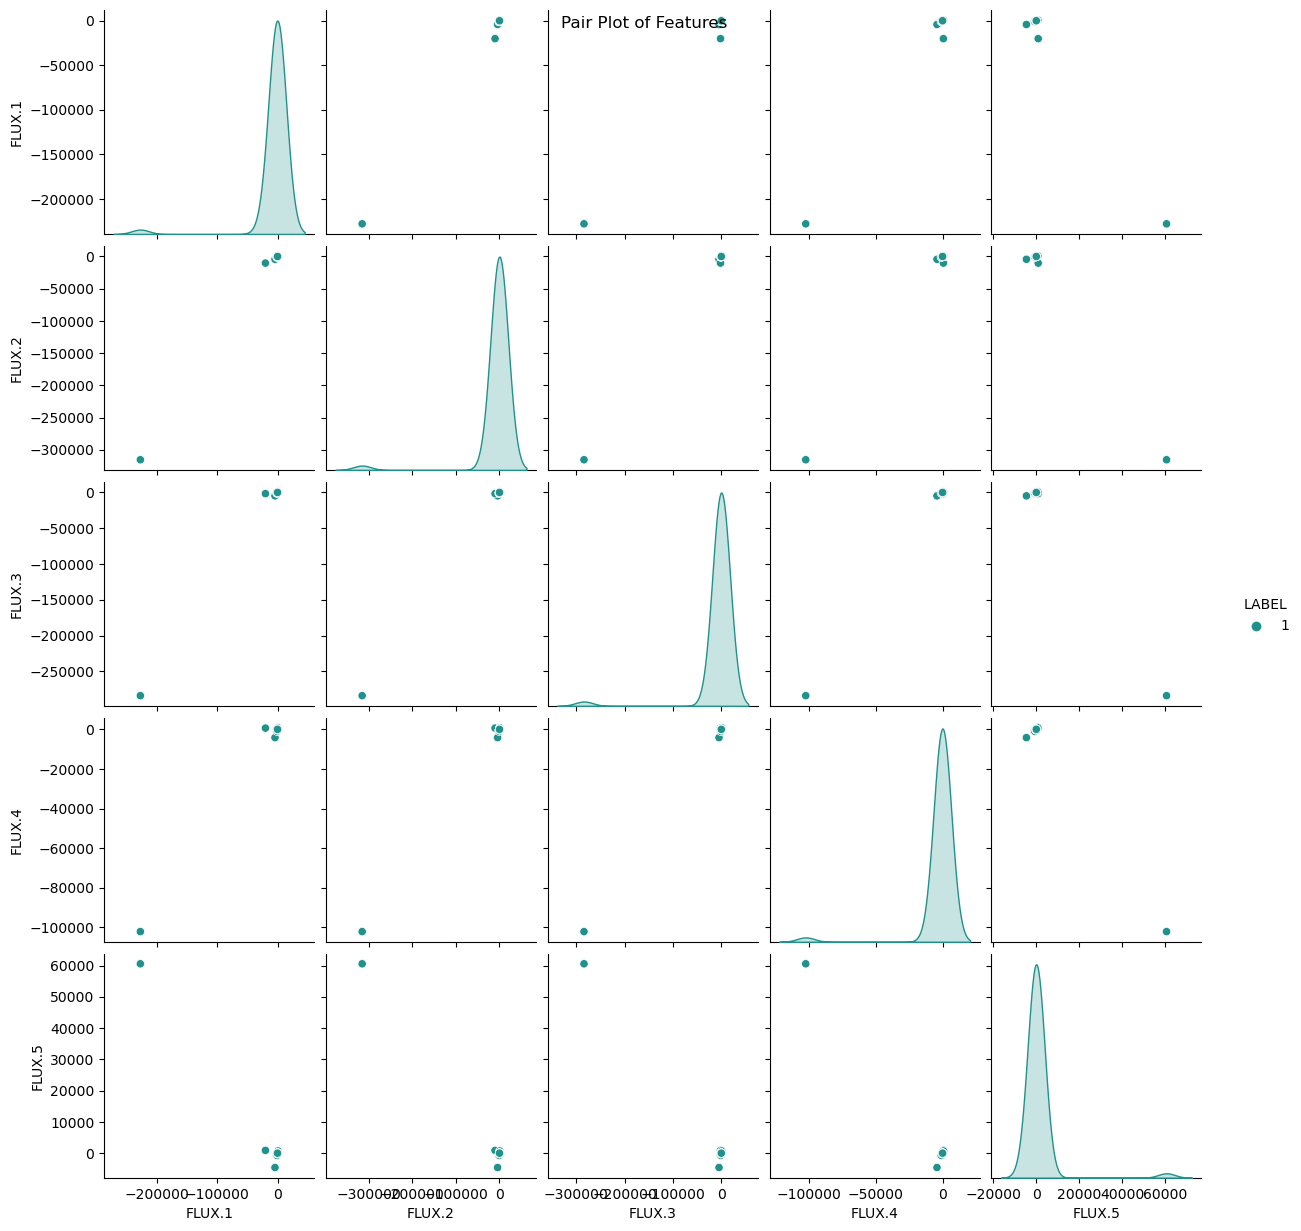

In [6]:
# Pair plot to visualize relationships between features
# Taking smaller subset of the data
sampled_data = train_data.sample(50) #sample size adjusted to 50

# Selecting a smaller subset of features
features = sampled_data.iloc[:, 1:6]  # Select the first 5 features for example

# Adding the 'LABEL' column for coloring
features['LABEL'] = sampled_data['LABEL']

# Generate the pair plot with a fresh color palette and hue
sns.pairplot(features, hue='LABEL', palette='viridis')
plt.suptitle('Pair Plot of Features')
plt.show()


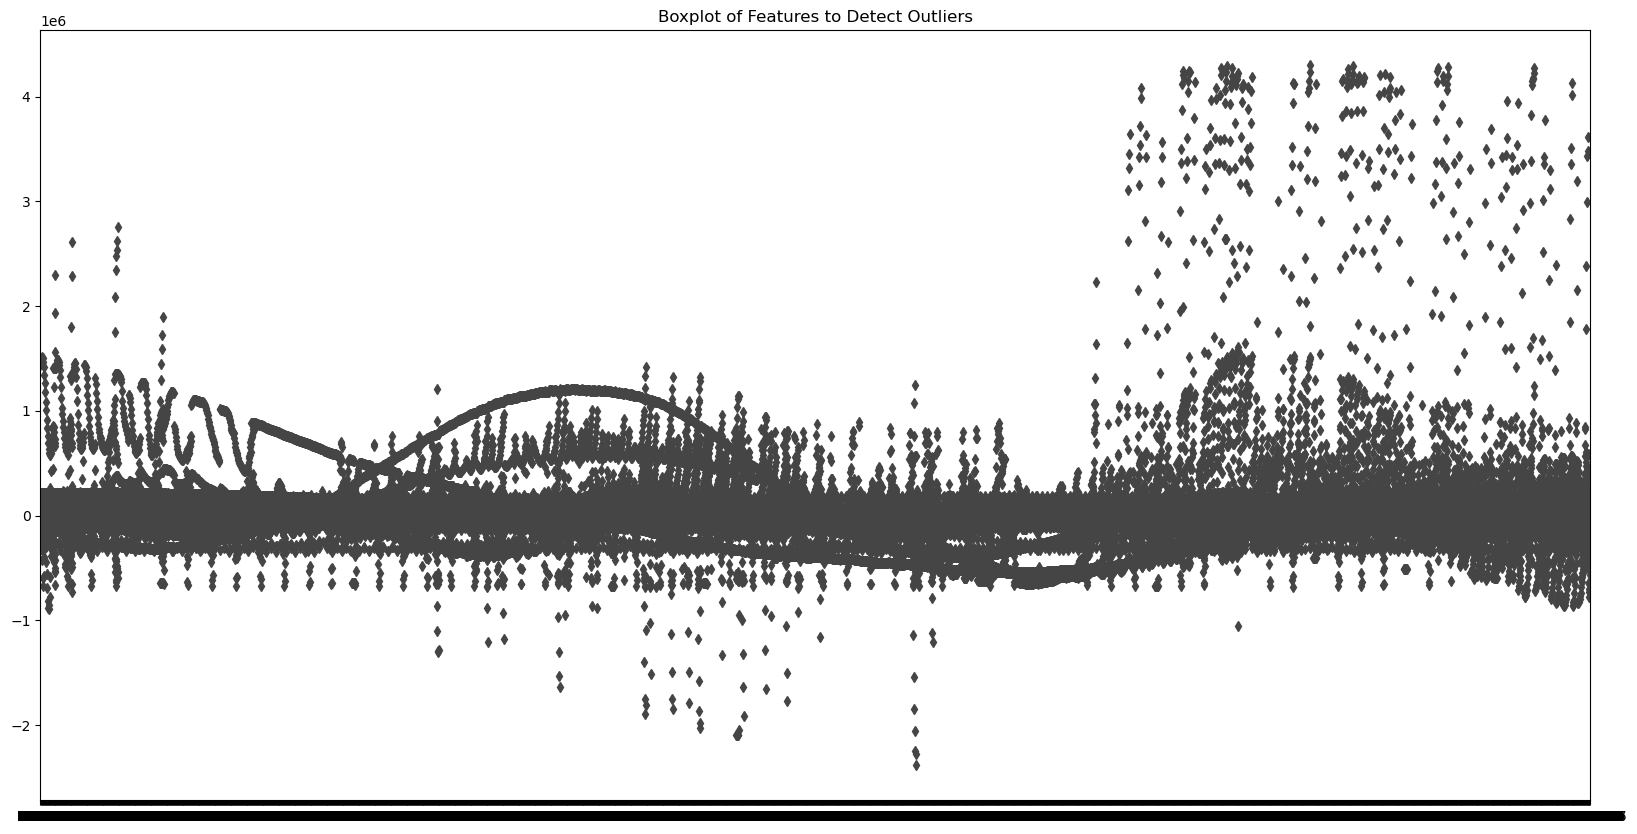

In [37]:
# Boxplot to visualize outliers
plt.figure(figsize=(20, 10))
sns.boxplot(data=train_data.iloc[:, 1:])
plt.title('Boxplot of Features to Detect Outliers')
plt.show()

In [40]:
train_y=train_data[train_data['LABEL'] == 1]
train_n=train_data[train_data['LABEL'] < 1]
train_t_n=train_n.iloc[:,1:].T
train_t_y=train_y.iloc[:,1:].T
train_t_y.head(1)

0      1       2       3        4      5     6       7       8   \
FLUX.1  93.85 -38.88  532.64  326.52 -1107.21  211.1  9.34  238.77 -103.54   

            9   ...      27    28     29     30      31     32     33      34  \
FLUX.1 -265.91  ...  124.39 -63.5  31.29 -472.5  194.82  26.96  43.07 -248.23   

           35     36  
FLUX.1  22.82  26.24  

[1 rows x 37 columns]

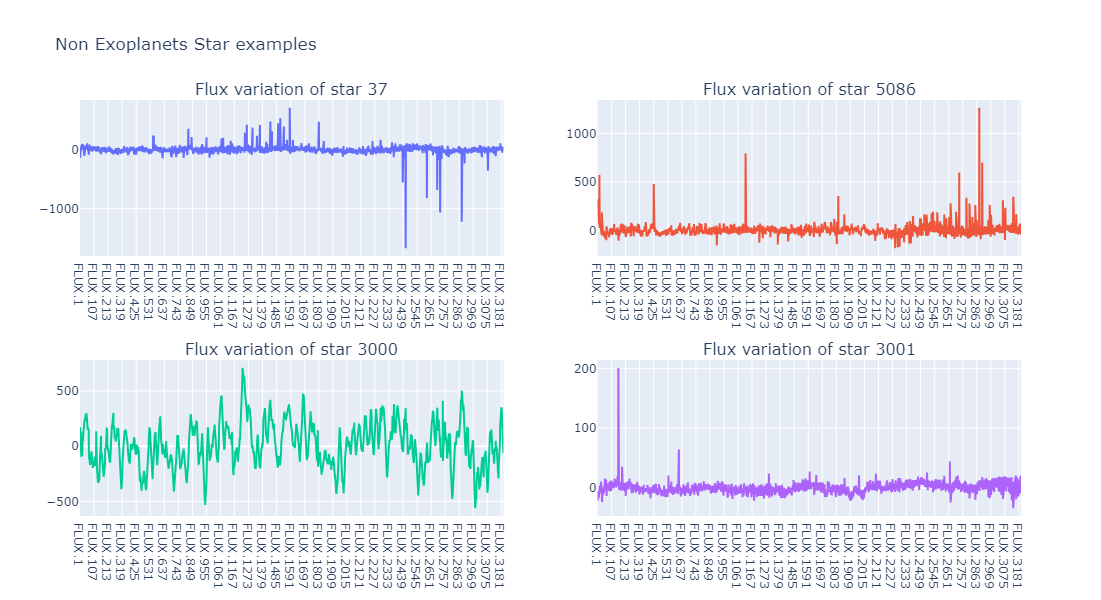

In [41]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots(rows=2, cols=2,subplot_titles=("Flux variation of star 37", "Flux variation of star 5086", 
                                                   "Flux variation of star 3000", "Flux variation of star 3001"))
fig.add_trace(
    go.Scatter(y=train_t_n[37], x=train_t_n.index),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(y=train_t_n[5086], x=train_t_n.index),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(y=train_t_n[3000], x=train_t_n.index),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(y=train_t_n[3001], x=train_t_n.index),
    row=2, col=2
)
fig.update_layout(height=600, width=800, title_text="Non Exoplanets Star examples",showlegend=False)
fig.show()

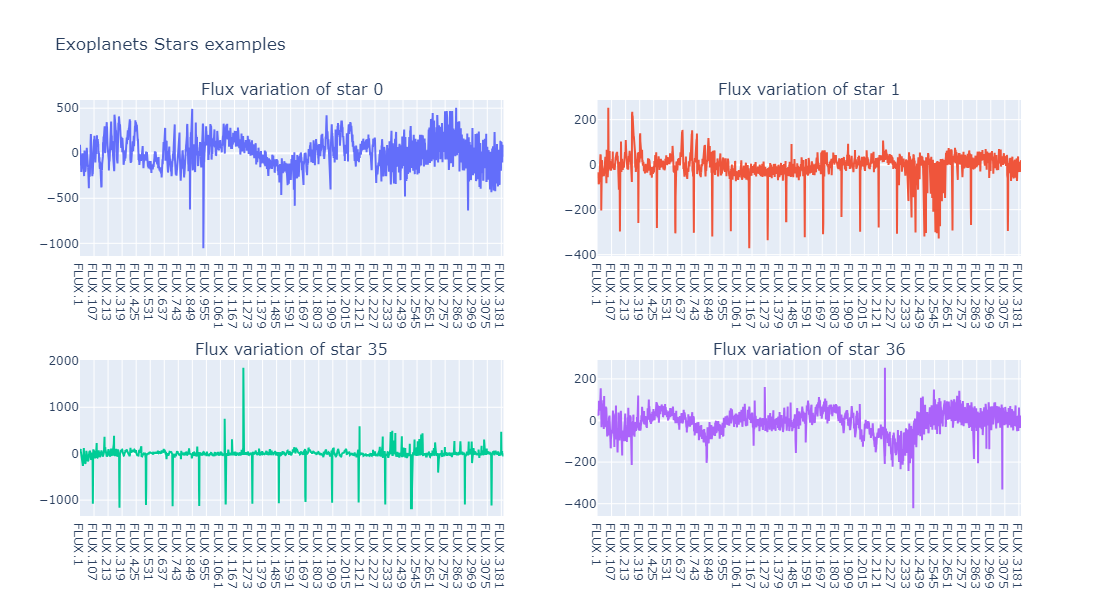

In [42]:
fig = make_subplots(rows=2, cols=2,subplot_titles=("Flux variation of star 0", "Flux variation of star 1", 
                                                   "Flux variation of star 35", "Flux variation of star 36"))
fig.add_trace(
    go.Scatter(y=train_t_y[0], x=train_t_y.index),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(y=train_t_y[1], x=train_t_y.index),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(y=train_t_y[35], x=train_t_y.index),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(y=train_t_y[36], x=train_t_y.index),
    row=2, col=2
)
fig.update_layout(height=600, width=800, title_text="Exoplanets Stars examples",showlegend=False)

In [44]:
#Normalising the Flux
trainx=train_data.iloc[:,1:]
textx=test_data.iloc[:,1:]
scaler=StandardScaler()
train_scaled=scaler.fit_transform(trainx)
test_scaled=scaler.fit_transform(textx)


In [15]:
# Separate features and labels
X_train = train_data.iloc[:, 1:]
y_train = train_data.LABEL
X_test = test_data.iloc[:, 1:]
y_test = test_data.LABEL

In [16]:
# Standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# Apply PCA
pca = PCA(n_components=6)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

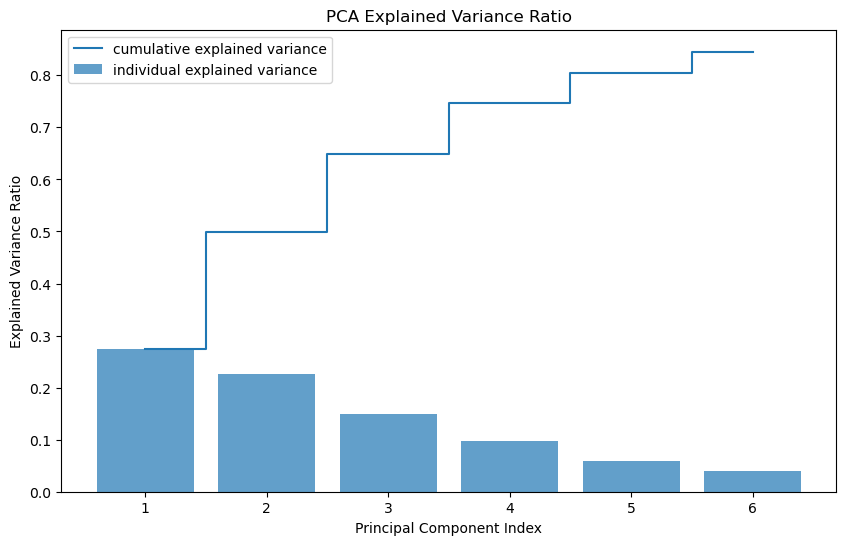

In [18]:
# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, 7), pca.explained_variance_ratio_, alpha=0.7, align='center', label='individual explained variance')
plt.step(range(1, 7), np.cumsum(pca.explained_variance_ratio_), where='mid', label='cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component Index')
plt.legend(loc='best')
plt.title('PCA Explained Variance Ratio')
plt.show()

In [19]:
# Apply SMOTE
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train_pca, y_train)

In [20]:
# Split data for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_smote, y_train_smote, test_size=0.2, random_state=0)

In [21]:
# Define and train models
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions) * 100
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test))
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")
    print(f"AUC-ROC: {roc_auc:.2f}")
    print(confusion_matrix(y_test, predictions))
    print(classification_report(y_test, predictions))
    return accuracy, precision, recall, f1, roc_auc

In [22]:
# Support Vector Machine with RBF kernel
print("SVM with RBF Kernel:")
svm_rbf = SVC(kernel='rbf', probability=True)
svm_rbf_results = train_and_evaluate_model(svm_rbf, X_train_smote, y_train_smote, X_test_pca, y_test)

SVM with RBF Kernel:
Accuracy: 98.95%
Precision: 0.33
Recall: 0.20
F1-score: 0.25
AUC-ROC: 0.61
[[563   2]
 [  4   1]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       565
           1       0.33      0.20      0.25         5

    accuracy                           0.99       570
   macro avg       0.66      0.60      0.62       570
weighted avg       0.99      0.99      0.99       570



In [23]:
# Logistic Regression
print("Logistic Regression:")
logreg = LogisticRegression()
logreg_results = train_and_evaluate_model(logreg, X_train_smote, y_train_smote, X_test_pca, y_test)


Logistic Regression:
Accuracy: 93.51%
Precision: 0.03
Recall: 0.20
F1-score: 0.05
AUC-ROC: 0.57
[[532  33]
 [  4   1]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.97       565
           1       0.03      0.20      0.05         5

    accuracy                           0.94       570
   macro avg       0.51      0.57      0.51       570
weighted avg       0.98      0.94      0.96       570



In [24]:
# Neural Network
model = keras.models.Sequential([
    keras.layers.Dense(300, activation="selu", input_shape=(X_train_split.shape[1],)),
    keras.layers.Dense(200, activation="selu", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="selu", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train_split, y_train_split, epochs=50, validation_data=(X_val_split, y_val_split), verbose=0)

print("Neural Network:")
nn_predictions = (model.predict(X_test_pca) > 0.5).astype("int32")
nn_accuracy = accuracy_score(y_test, nn_predictions) * 100
nn_precision = precision_score(y_test, nn_predictions)
nn_recall = recall_score(y_test, nn_predictions)
nn_f1 = f1_score(y_test, nn_predictions)
nn_roc_auc = roc_auc_score(y_test, model.predict(X_test_pca))
print(f"Accuracy: {nn_accuracy:.2f}%")
print(f"Precision: {nn_precision:.2f}")
print(f"Recall: {nn_recall:.2f}")
print(f"F1-score: {nn_f1:.2f}")
print(f"AUC-ROC: {nn_roc_auc:.2f}")
print(confusion_matrix(y_test, nn_predictions))
print(classification_report(y_test, nn_predictions))
nn_results = (nn_accuracy, nn_precision, nn_recall, nn_f1, nn_roc_auc)

Neural Network:
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 82.81%
Precision: 0.01
Recall: 0.20
F1-score: 0.02
AUC-ROC: 0.54
[[471  94]
 [  4   1]]
              precision    recall  f1-score   support

           0       0.99      0.83      0.91       565
           1       0.01      0.20      0.02         5

    accuracy                           0.83       570
   macro avg       0.50      0.52      0.46       570
weighted avg       0.98      0.83      0.90       570



In [25]:

# XGBoost
print("XGBoost:")
xgb = XGBClassifier(scale_pos_weight=0.33)
xgb_results = train_and_evaluate_model(xgb, X_train_smote, y_train_smote, X_test_pca, y_test)

XGBoost:
Accuracy: 97.89%
Precision: 0.00
Recall: 0.00
F1-score: 0.00
AUC-ROC: 0.60
[[558   7]
 [  5   0]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       565
           1       0.00      0.00      0.00         5

    accuracy                           0.98       570
   macro avg       0.50      0.49      0.49       570
weighted avg       0.98      0.98      0.98       570



In [26]:
# Results Analysis
results_df = pd.DataFrame({
    'Model': ['SVM with RBF Kernel', 'Logistic Regression', 'Neural Network', 'XGBoost'],
    'Accuracy': [svm_rbf_results[0], logreg_results[0], nn_results[0], xgb_results[0]],
    'Precision': [svm_rbf_results[1], logreg_results[1], nn_results[1], xgb_results[1]],
    'Recall': [svm_rbf_results[2], logreg_results[2], nn_results[2], xgb_results[2]],
    'F1-score': [svm_rbf_results[3], logreg_results[3], nn_results[3], xgb_results[3]],
    'AUC-ROC': [svm_rbf_results[4], logreg_results[4], nn_results[4], xgb_results[4]]
})

print("\nModel Comparison:")
print(results_df)


Model Comparison:
                 Model   Accuracy  Precision  Recall  F1-score   AUC-ROC
0  SVM with RBF Kernel  98.947368   0.333333     0.2  0.250000  0.613451
1  Logistic Regression  93.508772   0.029412     0.2  0.051282  0.570619
2       Neural Network  82.807018   0.010526     0.2  0.020000  0.537345
3              XGBoost  97.894737   0.000000     0.0  0.000000  0.596814


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


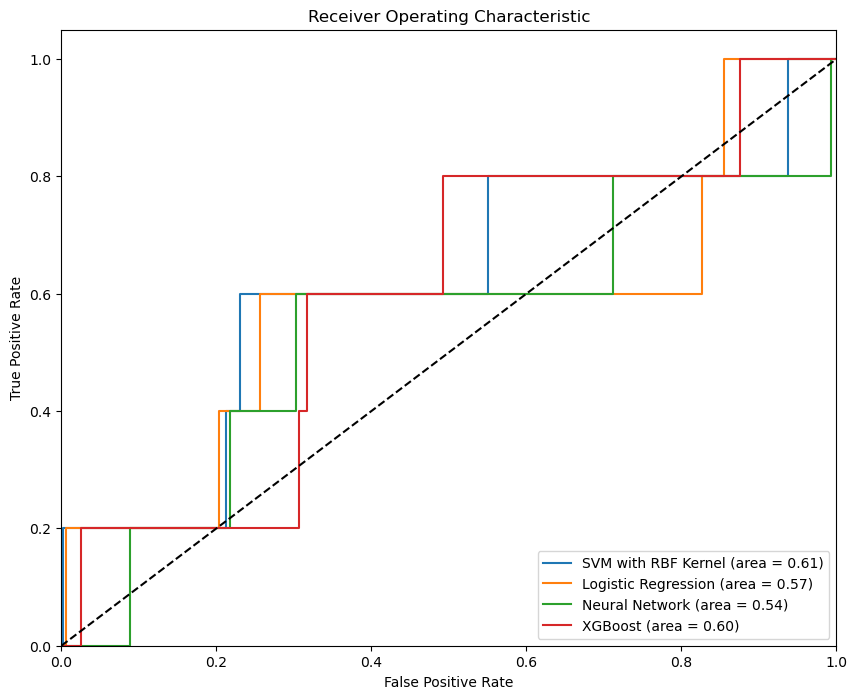

In [27]:
# Plotting the ROC curves
plt.figure(figsize=(10, 8))

models = {
    'SVM with RBF Kernel': svm_rbf,
    'Logistic Regression': logreg,
    'Neural Network': model,
    'XGBoost': xgb
}

for model_name, model in models.items():
    if model_name == "Neural Network":
        y_pred_proba = model.predict(X_test_pca)
    else:
        y_pred_proba = model.predict_proba(X_test_pca)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

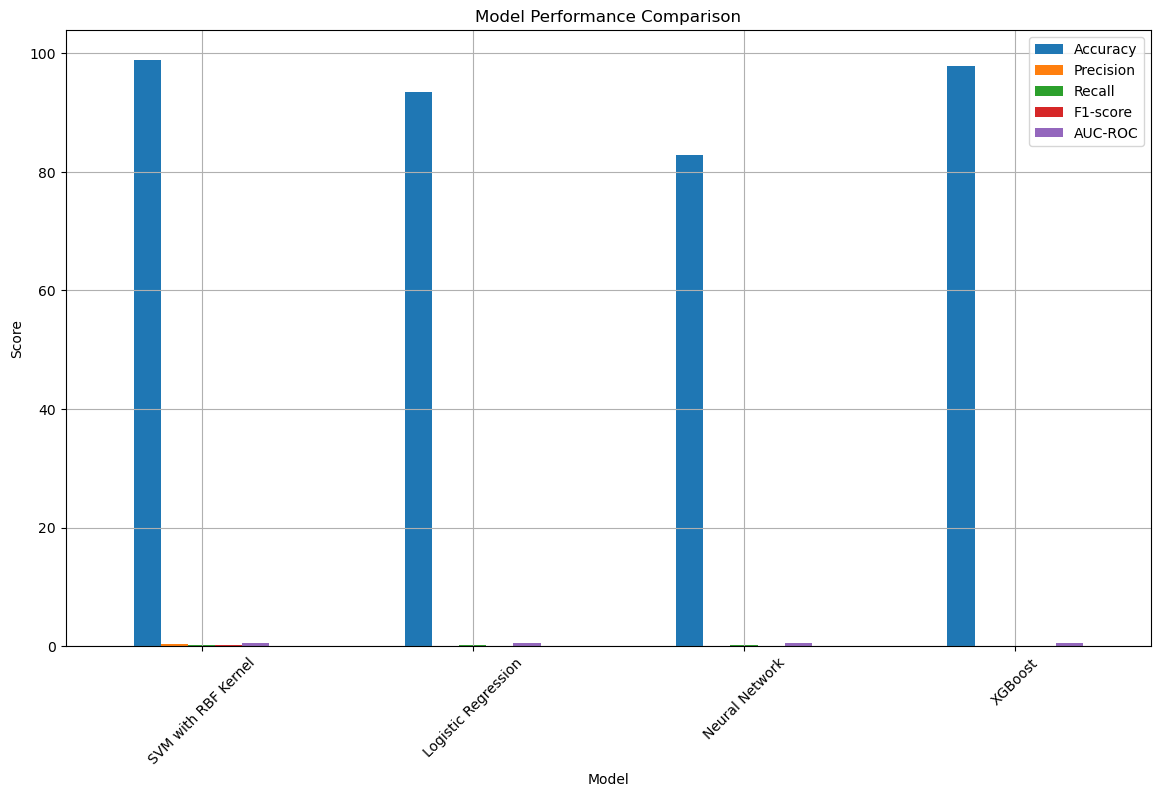

In [28]:
# Plot model performance comparison
results_df.set_index('Model', inplace=True)
results_df.plot(kind='bar', figsize=(14, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

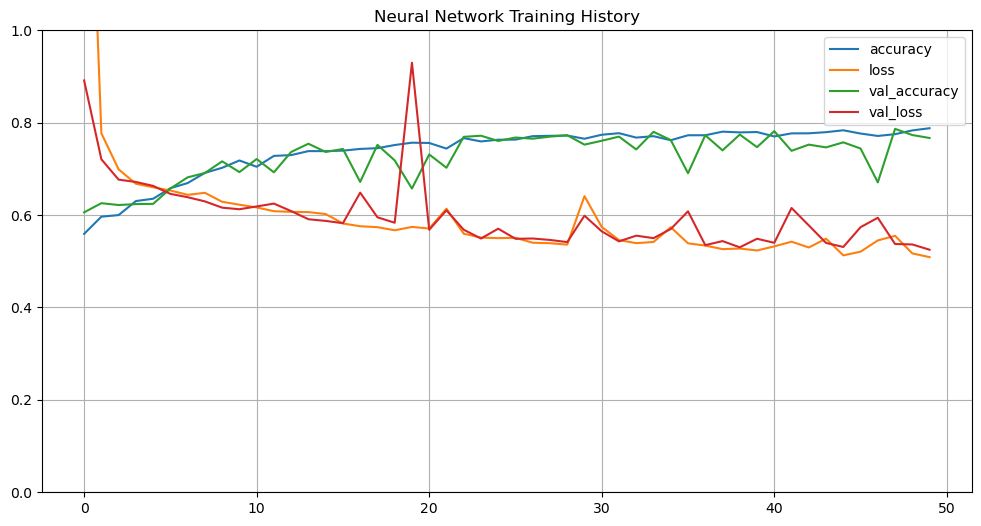

In [29]:
# Visualize training history for neural network
pd.DataFrame(history.history).plot(figsize=(12, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title('Neural Network Training History')
plt.show()